# Pre-trained models and transfer learning

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [1]:
!pip install torchinfo

In [2]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2021-07-18 18:35:56--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2021-07-18 18:35:56 (86.0 MB/s) - ‘pytorchcv.py’ saved [6371/6371]



In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time!):

In [4]:
if not os.path.exists("data/kagglecatsanddogs_3367a.zip"):  # exists: Test whether a path exists. Returns False for broken symbolic links
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
    # -P: directory prefix (where files will be saved);  # -q: quiet (no output)

In [5]:
import zipfile
if not os.path.exists("data/PetImages"):
    with zipfile.ZipFile("data/kagglecatsanddogs_3367a.zip", 'r') as zip_ref:  # ZipFile: class for reading and writing ZIP files. mode='r': to read an existing file
        zip_ref.extractall("data")  # 先將壓縮檔使用 zipfile 讀取，並使用 extractall() 函式解壓縮

Unfortunately, there are some corrupt image files in the dataset. We need to do quick cleaning to check for corrupted files. In order not to clobber this tutorial, we moved the code to verify dataset into a module.

In [6]:
check_image_dir("data/PetImages/Cat/*.jpg")
check_image_dir("data/PetImages/Dog/*.jpg")

# what pytorchcv.check_image_dir does is:
#
# from PIL import Image
# import glob
# 
# def check_image(fn):
#     try:
#         im = Image.open(fn)
#         im.verify()  # verify(): determine if the file is broken. If broken, raise exception
#         return True
#     except:
#         return False
# 
# def check_image_dir(path):
#     for fn in glob.glob(path):  # glob(): Return a possibly-empty list of path names that match pathname
#         if not check_image(fn):
#             print("Corrupt image: {}".format(fn))
#             os.remove(fn)  # remove file

Corrupt image: data/PetImages/Cat/666.jpg
Corrupt image: data/PetImages/Dog/11702.jpg


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

In [7]:
# Dealing with following two warning when reading PIL image:
#     UserWarning: Possibly corrupt EXIF data.
#     UserWarning: Corrupt EXIF data
# This is because some of the images have corrupted exif info. We won't need it. Can ignore
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=r'.*EXIF.*')  # message is in regular expression; .* will match the whole string befor/after EXIF

Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We will apply `std_normalize` transform to bring images to the range expected by pre-trained VGG network:

Total numbers of samples in cleaned dataset: 24998


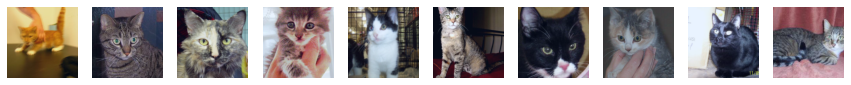

In [8]:
std_normalize = transforms.Normalize(  # Normalize: Normalize a tensor image with mean and standard deviation.
    mean=[0.485, 0.456, 0.406], # mean and std of ImageNet
    std=[0.229, 0.224, 0.225]
)

trans = transforms.Compose([
    transforms.Resize(size=256),  # If size is an int, smaller edge of the image will be matched to this number.
    transforms.CenterCrop(224),  # If image size is smaller than output size along any edge, image is padded with 0 and then center cropped.
    transforms.ToTensor(),
    std_normalize
])

dataset = torchvision.datasets.ImageFolder(root="data/PetImages", transform=trans)  # ImageFolder: images are arranged in root/[class]/[...]/image0
trainset, testset = torch.utils.data.random_split(dataset=dataset, lengths=[20000, len(dataset) - 20000])  # Randomly split a dataset into non-overlapping new datasets of given lengths. But no guarantee to return balanced data
                                                                                                           # if needing strictly the same distribution: create the training and testing indices with "sklearn.model_selection.train_test_split" and pass the target array to "stratify" argument. The returned train and test indices can then be used in Subset to create the datasets.
display_dataset(dataset)
print(f"Total numbers of samples in cleaned dataset: {len(dataset)}")

## Pre-trained models

There are many different pre-trained models available inside `torchvision` module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:

In [9]:
vgg = torchvision.models.vgg16(pretrained=True)  # pretrained on ImageNet
sample_image = dataset[0][0].unsqueeze(0)  # Returns a new tensor with a dimension of one more size inserted at the specified position
res = vgg(sample_image)  # res: size([N, Total_Class])
print(res[0].argmax())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(282)


The result that we have received is a number of an `ImageNet` class, which can be looked up [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can use the following code to automatically load this class table and return the result:

In [10]:
import json, requests  # requests.get(): return a "Response" object from a webpage, can get all the information needed from this object  # .text: read the content of the server’s response, return a string
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)  # json.load(fp): deserialize fp (a str, bytes or bytearray instance containing a JSON document) to a Python object. return a dict
class_map = {int(k): v for k, v in class_map.items()}  # When looping through dictionaries, the key and corresponding value can be retrieved at the same time using the items() method

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

Let's also see the architecture of the VGG-16 network:

In [11]:
summary(vgg, input_size=(1, 3, 224, 224))  # nn.AdaptiveAvgPool2d(output_size): The output is of size H x W, for any input size

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In addition to the layer we already know, there is also another layer type called **Dropout**. These layers act as **regularization** technique. Regularization makes slight modifications to the learning algorithm so the model generalizes better. During training, dropout layers discard some proportion (around 30%) of the neurons in the previous layer, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between different neural paths, which improves overall stability of the network.

## GPU computations

Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. In order to do so, we need to explicitly move all tensors involved in the computation to GPU.

The way it is normally done is to check the availability of GPU in the code, and define `device` variable that points to the computational device - either GPU or CPU.


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(281, device='cuda:0')


## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

torch.Size([1, 512, 7, 7])
<class 'torch.Tensor'> tensor(0.) tensor(27.2867)


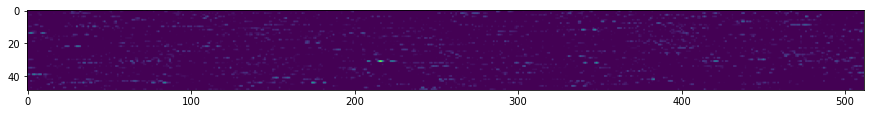

In [13]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15, 3))             # imshow(): By default, a linear scaling mapping the lowest value to 0 and the highest to 1 is used, before mapping to colors using cmap
plt.imshow(res.detach().view(-1, 512))  # imshow(): Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead. (tensor.detach() is OK either)
print(res.size())
print(type(res.detach()), res.detach().min(), res.detach().max())

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

In [14]:
bs = 8
dl = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
num = bs * 100
feature_tensor = torch.zeros(num, 512 * 7 * 7).to(device)
label_tensor = torch.zeros(num).to(device)  # zeros(): The default dtype is torch.float (=torch.float32).
i = 0
for x, l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i: i + bs] = f.view(bs, -1)  # can assign as long as non-singleton dimension match
        label_tensor[i: i + bs] = l
        i += bs
        print('.', end='')  # end: string appended after the last value, default a newline (\n).
        if i >= num:
            break

....................................................................................................

In [15]:
label_tensor[0].dtype

torch.float32

Now we can define `vgg_dataset` that takes data from this tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.913, Val acc=0.950, Train loss=0.083, Val loss=0.077
Epoch  1, Train acc=0.963, Val acc=0.980, Train loss=0.048, Val loss=0.048
Epoch  2, Train acc=0.993, Val acc=0.980, Train loss=0.011, Val loss=0.043
Epoch  3, Train acc=0.999, Val acc=0.980, Train loss=0.002, Val loss=0.045
Epoch  4, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.046
Epoch  5, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.046
Epoch  6, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.046
Epoch  7, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.046
Epoch  8, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.046
Epoch  9, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.046


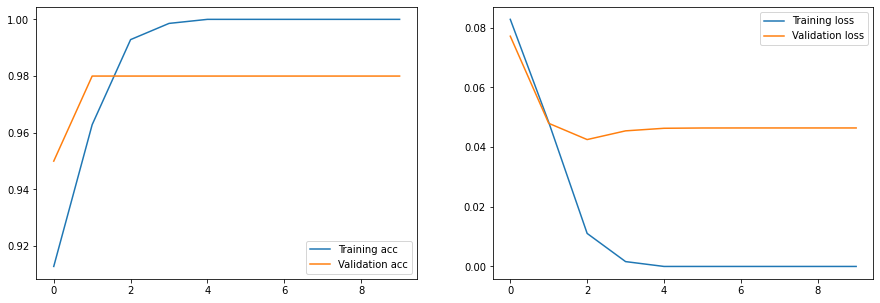

In [16]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor.to(torch.long))  # TensorDataset(*tensors): Each sample will be retrieved by indexing tensors along the first dimension. *tensors: input tensors that have the same size of the first dimension.  # torch.long=torch.int64
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset, lengths=[700, 100])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512 * 7 * 7, 2), torch.nn.LogSoftmax()).to(device)

history = train(net, train_loader, test_loader)

plot_results(history)

The result is great, we can distinguish between a cat and a dog with almost 98% probability! However, we have only tested this approach on a small subset of all images, because manual feature extraction seems to take a lot of time.

## Transfer learning using one VGG network

We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

In [17]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

You can see that the network contains:
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset, we need to:
* **replace the final classifier** with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* **freeze weights of convolutional feature extractor**, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters to `False`

In [18]:
vgg.classifier = torch.nn.Linear(25088, 2).to(device)  # need .to(device) explicitly, because weights in a module are allowed to be on different devices, and here we add new weights (default on cpu) after vgg.to(device)

for x in vgg.features.parameters():  # can get the parameters of each class member
    x.requires_grad = False  # vgg.avgpool is not trainable, no need to freeze it

summary(vgg, input_size=(1, 3, 244, 244))  # Trainable params will consider only the ones with requires_grad=True

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

As you can see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now let's train the model using our original dataset. This process will take a long time, so we will use `train_long` function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!

In [19]:
trainset, testset = torch.utils.data.random_split(dataset, lengths=[20000, len(dataset) - 20000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16)

train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90)

# what torchcv.train_long does is:
#
# def validate(net, dataloader,loss_fn=nn.NLLLoss()):
#     net.eval()
#     count,acc,loss = 0,0,0
#     with torch.no_grad():
#         for features,labels in dataloader:
#             lbls = labels.to(default_device)
#             out = net(features.to(default_device))
#             loss += loss_fn(out,lbls) 
#             pred = torch.max(out,1)[1]  # torch.max() with dim arguement specified: return torch.return_types.max namedtuple (values, indices)
#             acc += (pred==lbls).sum()
#             count += len(labels)
#     return loss.item()/count, acc.item()/count
# 
# def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
#     optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
#     for epoch in range(epochs):
#         net.train()
#         total_loss,acc,count = 0,0,0
#         for i, (features,labels) in enumerate(train_loader):
#             lbls = labels.to(default_device)
#             optimizer.zero_grad()
#             out = net(features.to(default_device))
#             loss = loss_fn(out,lbls)
#             loss.backward()
#             optimizer.step()
#             total_loss+=loss
#             _,predicted = torch.max(out,1)
#             acc+=(predicted==lbls).sum()
#             count+=len(labels)
#             if i%print_freq==0:
#                 print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
#         vl,va = validate(net,test_loader,loss_fn)
#         print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))

Epoch 0, minibatch 0: train acc = 0.5625, train loss = 0.05411906912922859
Epoch 0, minibatch 90: train acc = 0.9326923076923077, train loss = 0.154548582139906
Epoch 0, minibatch 180: train acc = 0.9533839779005525, train loss = 0.13140129384414925
Epoch 0, minibatch 270: train acc = 0.9577952029520295, train loss = 0.12399938097739131
Epoch 0, minibatch 360: train acc = 0.9610457063711911, train loss = 0.12105912184781314
Epoch 0, minibatch 450: train acc = 0.9629988913525499, train loss = 0.1316730050977212
Epoch 0, minibatch 540: train acc = 0.9655730129390019, train loss = 0.13095080081283936
Epoch 0, minibatch 630: train acc = 0.9677099841521395, train loss = 0.13345147086021072
Epoch 0, minibatch 720: train acc = 0.9682732316227461, train loss = 0.1384751932300245
Epoch 0, minibatch 810: train acc = 0.968634401972873, train loss = 0.1430201030688868
Epoch 0, minibatch 900: train acc = 0.9693396226415094, train loss = 0.14667814976631868
Epoch 0, minibatch 990: train acc = 0.9698

Epoch 0, minibatch 0: train acc = 0.375, train loss = 0.04666859656572342
Epoch 0 done, validation acc = 0.6964785914365746, validation loss = 0.36612181493691226
Epoch 0, minibatch 90: train acc = 0.9436813186813187, train loss = 0.0928346193753756
Epoch 0 done, validation acc = 0.97218887555022, validation loss = 0.06708372435888418
Epoch 0, minibatch 180: train acc = 0.9537292817679558, train loss = 0.12570002856175544
Epoch 0 done, validation acc = 0.9717887154861945, validation loss = 0.08960555657809999
Epoch 0, minibatch 270: train acc = 0.9580258302583026, train loss = 0.13015662612070455
Epoch 0 done, validation acc = 0.9747899159663865, validation loss = 0.09369927780682585
Epoch 0, minibatch 360: train acc = 0.9622576177285319, train loss = 0.12699618564087928
Epoch 0 done, validation acc = 0.9735894357743097, validation loss = 0.10914387727747349
Epoch 0, minibatch 450: train acc = 0.9646618625277162, train loss = 0.12984138370353207
Epoch 0 done, validation acc = 0.9609843

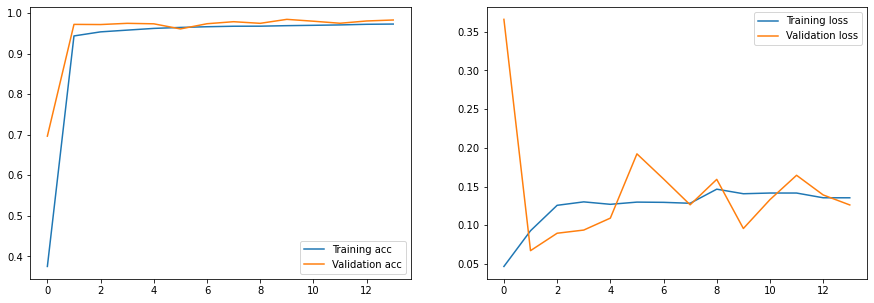

In [20]:
import pytorchcv

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(pytorchcv.default_device)  # In pytorchcv.py, default_device object didn't defined in builtins nor defined as a function/class. So even import pytorchcv, it still cannot directly be called by only the name "default_device"
            out = net(features.to(pytorchcv.default_device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}  # add res to record history
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(pytorchcv.default_device)
            optimizer.zero_grad()
            out = net(features.to(pytorchcv.default_device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
                vl,va = validate(net,test_loader,loss_fn)  # validate every print_freq
                print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))  # validate every print_freq
                res['train_loss'].append(total_loss.item()/count)  # add res to record history
                res['train_acc'].append(acc.item()/count)  # add res to record history
                res['val_loss'].append(vl)  # add res to record history
                res['val_acc'].append(va)  # add res to record history
    return res
                

vgg = torchvision.models.vgg16(pretrained=True).to(device)

vgg.classifier = torch.nn.Linear(25088, 2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90)

plot_results(hist)

It looks like we have obtained reasonably accurate cats vs. dogs classifier! Let's save it for future use!

In [21]:
torch.save(vgg,'data/cats_dogs.pth')

We can then load the model from file at any time. You may find it useful in case the next experiment destroys the model - you would not have to re-start from scratch.

In [22]:
vgg = torch.load('data/cats_dogs.pth')

## Fine-tuning transfer learning

In the previous section, we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen. 

> **Note:** It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

In [23]:
for x in vgg.features.parameters():  # parameters(): Returns an iterator
    x.requires_grad = True

summary(vgg)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

> **Note:** This training happens much slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0 done, validation acc = 0.9751900760304122, validation loss = 0.17818433525754052
Epoch 0, minibatch 90: train acc = 0.9072802197802198, train loss = 0.22566805829058637
Epoch 0 done, validation acc = 0.9323729491796718, validation loss = 0.04527274166502539
Epoch 0, minibatch 180: train acc = 0.9261049723756906, train loss = 0.13332604044708757
Epoch 0 done, validation acc = 0.9381752701080432, validation loss = 0.025294053168142257
Epoch 0, minibatch 270: train acc = 0.9370387453874539, train loss = 0.0946492761703435
Epoch 0 done, validation acc = 0.9551820728291317, validation loss = 0.021482163116711528
Epoch 0, minibatch 360: train acc = 0.9381925207756233, train loss = 0.07765586092201296
Epoch 0 done, validation acc = 0.9333733493397359, validation loss = 0.02032562903090924
Epoch 0, minibatch 450: train acc = 0.9397172949002217, train loss = 0.06590292141865732
Epoch 0 done, validation acc = 0.9453781512605042, val

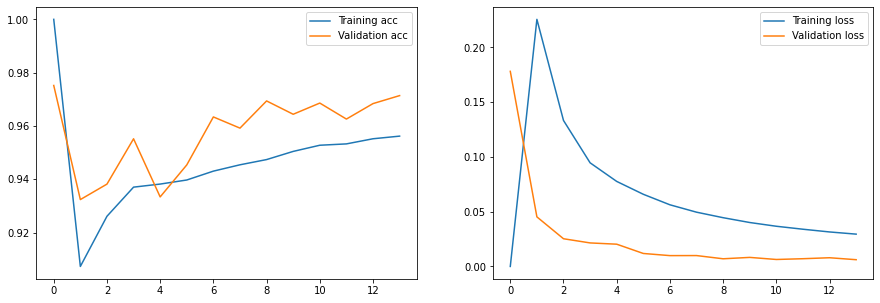

In [24]:
hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90, lr=0.0001)

plot_results(hist)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

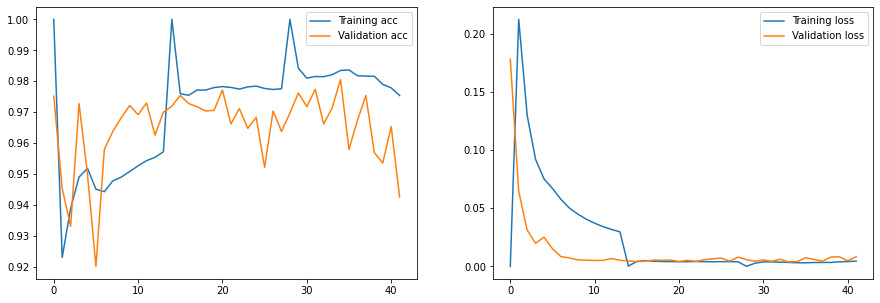

In [25]:
# more epochs=3
# same for the after experiments
vgg = torch.load("data/cats_dogs.pth")

for x in vgg.features.parameters():
    x.requires_grad = True

print(summary(vgg))

hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=3, print_freq=90, lr=0.0001)  # more epochs

plot_results(hist)

In [26]:
# ??why accuracy drop first then up??
# Maybe, it was already in a closer point to local minima, but initiall the lr makes it step a little bit over the minima

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

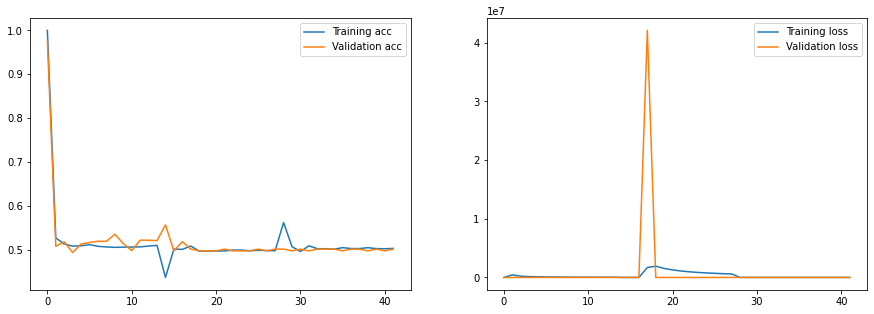

In [27]:
# ??what if lr is not smaller?? (with previously trained fc weights)
# initially much worser, maybe the higher learning rate makes it step too far over the original point closer to local minima (weights got impacted too much at first, can't save it by this small dataset even with longer epochs afterwards)
vgg = torch.load("data/cats_dogs.pth")

for x in vgg.features.parameters():
    x.requires_grad = True

print(summary(vgg))  # need to print the variable to show in jupyter notebook output if the variable is not at the last line of cell

hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=3, print_freq=90)  # larger (default) lr=0.01

plot_results(hist)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

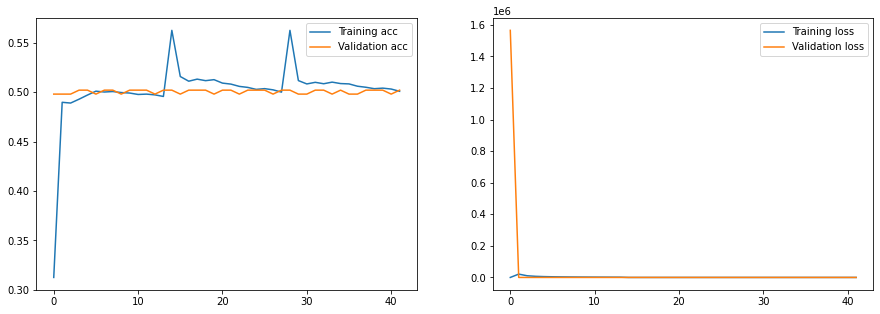

In [28]:
# ??What if pretrained weights of feature extractor aren't fixed, and directly train end-to-end whole network intead??
# initial large errors caused by wrong fc weight, will destroy the pre-trained weights in the convolutional layers in the first few steps, because of large updates caused by large total loss
vgg = torchvision.models.vgg16(pretrained=True)  # use pretrained weights for features extractor and didn't frozen them
vgg.to(device)
vgg.classifier = torch.nn.Linear(25088, 2).to(device)  # train random init classifier and pretrained-weight features extractor end-to-end directly

for x in vgg.features.parameters():
    x.requires_grad = True

print(summary(vgg))

hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=3, print_freq=90)  # larger (default) lr=0.01

plot_results(hist)

## Other computer vision models

VGG-16 is one of the simplest computer vision architectures. `torchvision` package provides many more pre-trained networks. The most frequently used ones among those are **ResNet** architectures, developed by Microsoft, and **Inception** by Google. For example, let's explore the architecture of the simplest ResNet-18 model (ResNet is a family of models with different depth, you can try experimenting with ResNet-151 if you want to see what a really deep model looks like):

In [29]:
resnet = torchvision.models.resnet18()
print(resnet)
print(summary(resnet))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

As you can see, the model contains the same building blocks: feature extractor and final classifier (`fc`). This allows us to use this model in exactly the same manner as we have been using VGG-16 for transfer learning. You can try experimenting with the code above, using different ResNet models as the base model, and see how accuracy changes.

## Batch Normalization

This network contains yet another type of layer: **Batch Normalization**. The idea of batch normalization is to bring values that flow through the neural network to right interval. Usually neural networks work best when all values are in the range of [-1,1] or [0,1], and that is the reason that we scale/normalize our input data accordingly. However, during training of a deep network, it can happen that values get significantly out of this range, which makes training problematic. Batch normalization layer computes average and standard deviation for all values of the current minibatch, and uses them to normalize the signal before passing it through a neural network layer. This significantly improves the stability of deep networks.


## Takeaway

Using transfer learning, we were able to quickly put together a classifier for our custom object classification task, and achieve high accuracy. However, this example was not completely fair, because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy on more exotic domain-specific objects, such as details on production line in a plant, or different tree leaves.

You can see that more complex tasks that we are solving now require higher computational power, and cannot be easily solved on the CPU. In the next unit, we will try to use more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy. 